# Advanced sktime features

In [49]:
import warnings
warnings.filterwarnings("ignore")

## Time-series transformers

Tranformers in `sktime` referr to a catch-all term that encompses modular data processing steps.

### Manual tranformations: doing things the wrong way

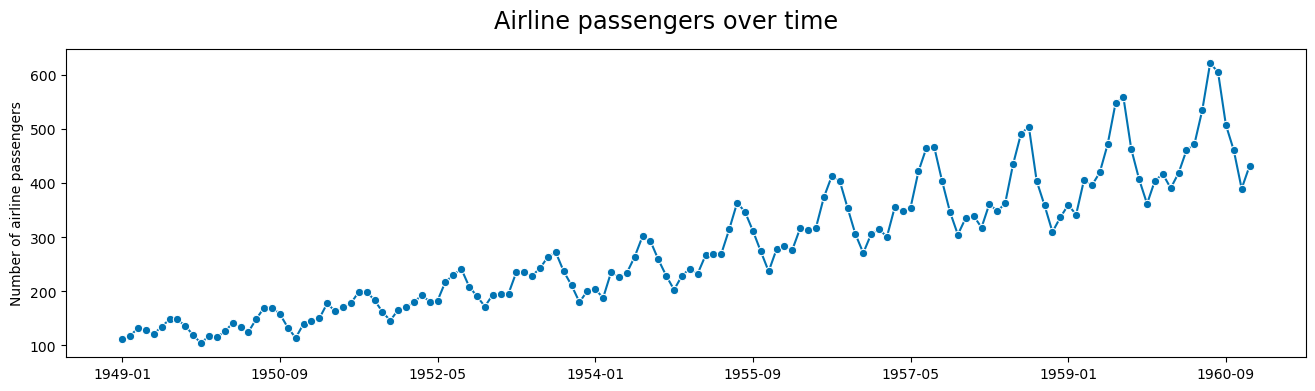

In [2]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()

fig, ax = plot_series(y, title="Airline passengers over time")

observations:

* there is seasonal periodicity, 12 month period
* seasonal periodicity looks multiplicative (not additive) to trend

idea: forecast might be easier

* with seasonality removed
* on logarithmic value scale (multiplication becomes addition)

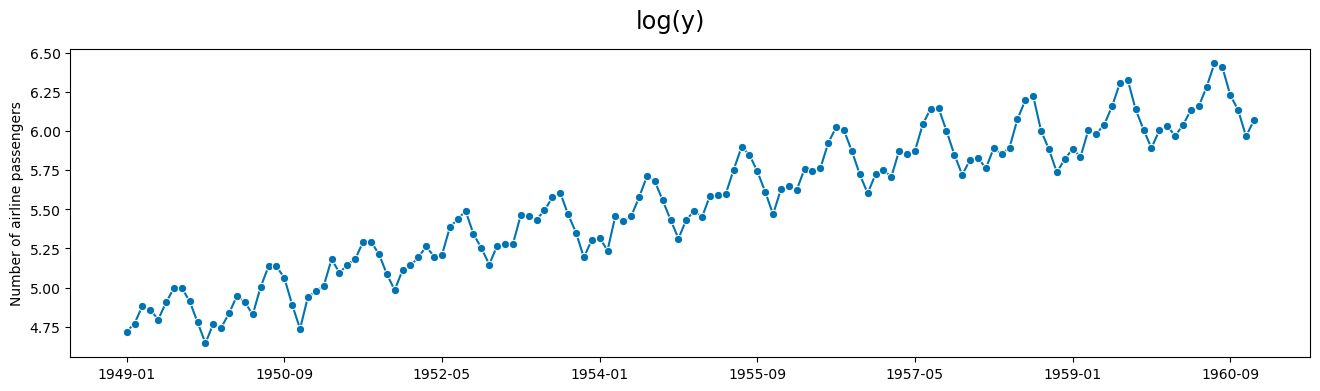

In [3]:
import numpy as np

y_log = np.log(y)

fig, ax = plot_series(y_log, title="log(y)")

Now the seasonality patterns looks constant over time, so we can decompose `log(y)` and then we can remove it.

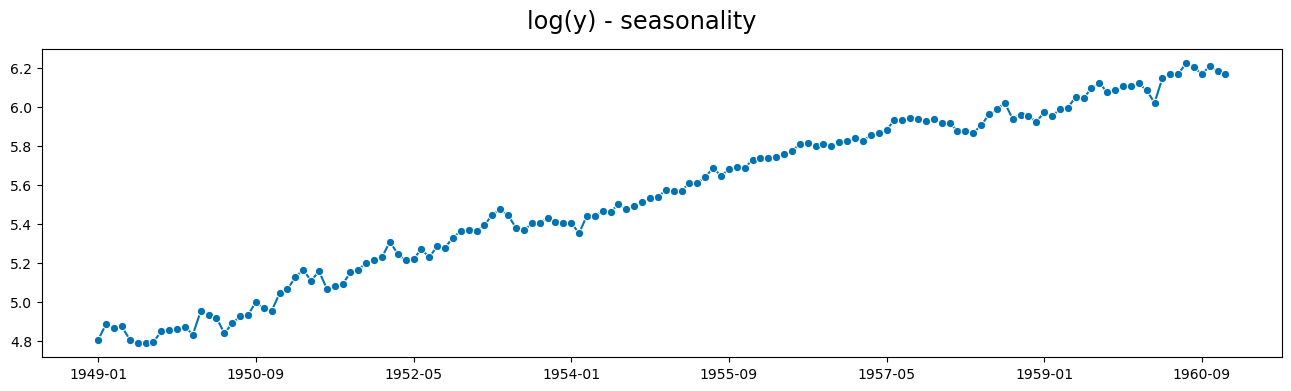

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_result = seasonal_decompose(y_log, period=12)
seasonal = seasonal_result.seasonal
y_log_deseasonalised = y_log - seasonal

fig, ax = plot_series(y_log_deseasonalised, title="log(y) - seasonality")

We can now forecast the log and deseasonalized data and then reverse the transformations to get back to the original scale.

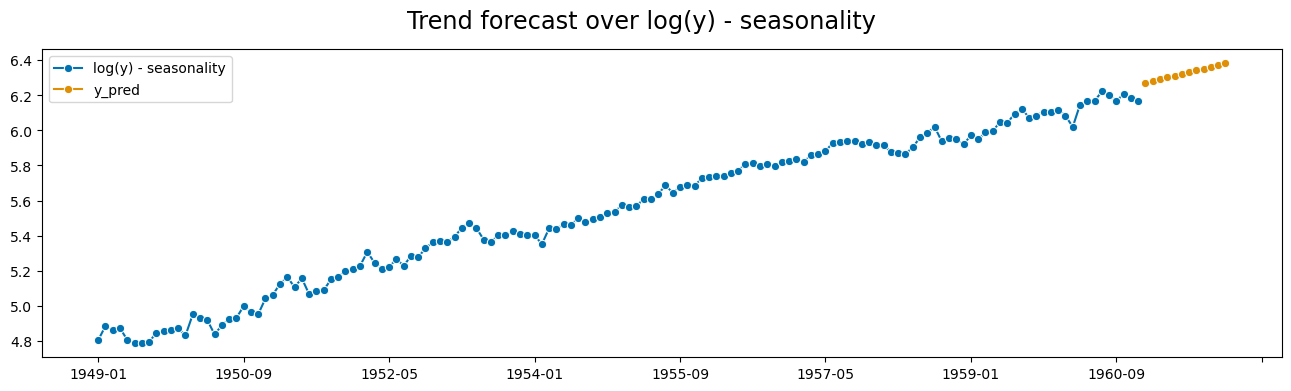

In [5]:
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()
y_pred = forecaster.fit_predict(y_log_deseasonalised, fh=list(range(1, 13)))

fig, ax = plot_series(
    y_log_deseasonalised,
    y_pred,
    labels=["log(y) - seasonality", "y_pred"],
    title="Trend forecast over log(y) - seasonality",
)

Looks reasonable! Now we have to turn this into a forecast of the original data by:
- Add back the seasonality
- Invert the logarithm

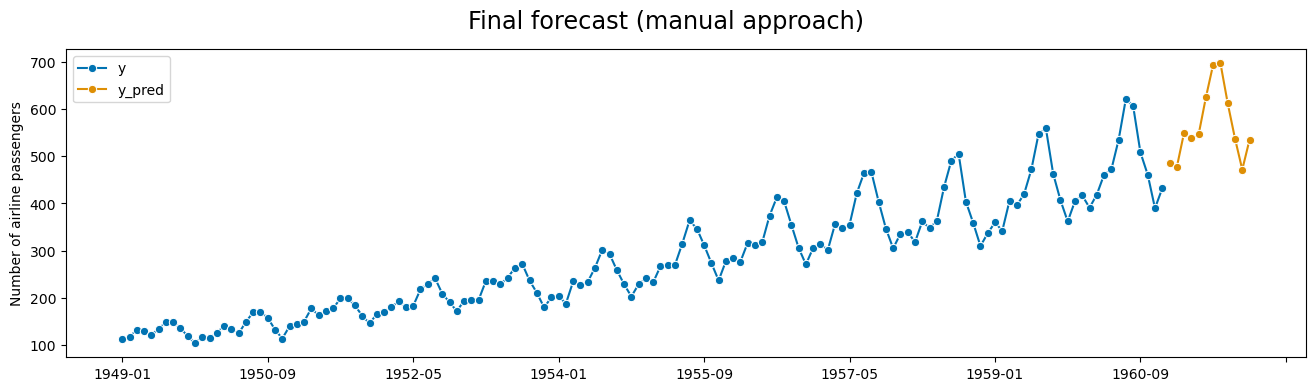

In [6]:
y_pred_add_seasonality = y_pred + seasonal[0:12].values
y_pred_orig = np.exp(y_pred_add_seasonality)

fig, ax = plot_series(y, y_pred_orig, labels=["y", "y_pred"], title="Final forecast (manual approach)")

Ok, done! But it was tedious!

### `sktime` transformers: doing things the right way

/usr/local/Caskroom/miniforge/base/envs/pydata_sktime/lib/python3.9/site-packages/sktime/forecasting/compose/_pipeline.py:91: UserWarning: in TransformedTargetForecaster, found steps of length 1, this will result in the same behaviour as not wrapping the single step in a pipeline. Consider not wrapping steps in TransformedTargetForecaster as it is redundant.
  warn(msg)


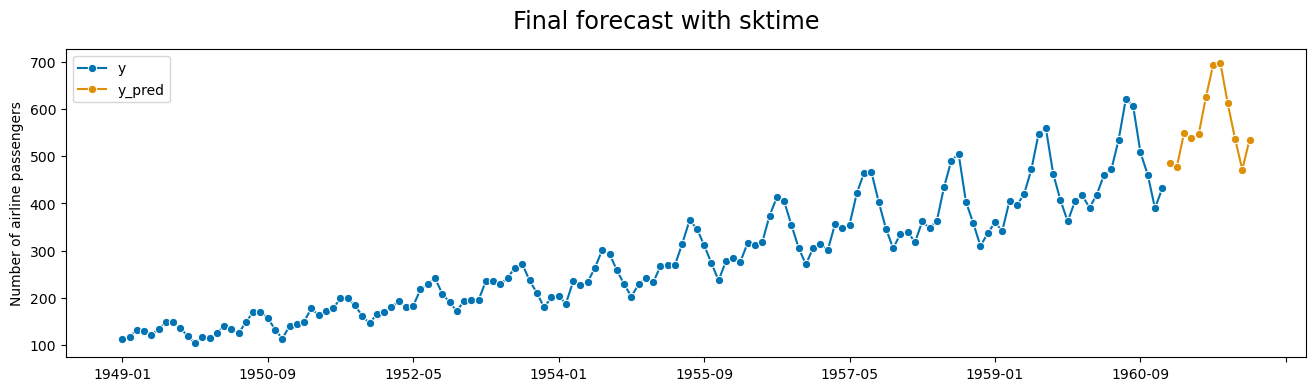

In [7]:
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

forecaster = LogTransformer() * Deseasonalizer(sp=12) * TrendForecaster()

y_pred = forecaster.fit_predict(y, fh=list(range(1, 13)))

fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"], title="Final forecast with sktime")

Let's break this down, what happened here?

The "chain" operator `*` creates a "forecasting pipeline". The pipeline is a sequence of steps that are applied to the data in order. The final forecaster has the same interface as all other forecasters, so we can use it directly without having to manually apply the transformations. More about pipelines later.

The log and deseasonalization transformations are implemented as `sktime` transformers. A transformer is a data processing step that can be applied to a time series. It has a `fit` and `transform` method. The transformations above are invertible, and this is used by the forecasting pipeline to invert the transformations when forecasting.

### Transformer type glossary

Common types of transformation in `sktime`:

| from | to | base class | examples (sci) | examples (`sktime`) |
| --- | --- | --- | --- | --- |
| time series | scalar features | `BaseTransformer` (`Primitives` output) | `tsfresh`, or 7-number-summary | `Catch22`,`SummaryTransformer` |
| time series | time series | `BaseTransformer` (`Series`, `instancewise`)  | detrending, smoothing, filtering, lagging | `Detrender`,`Differencer`, `Lag`, `Filter` |
| time series panel | also a panel | `BaseTransformer` (`Series` output)  | principal component projection | `PCATransformer`,`PaddingTransformer` |
| two feature vectors | a scalar | `BasePairwiseTransformer` | Euclidean distance, L1 distance | `ScipyDist`, `AggrDist`, `FlatDist` |
| two time series | a scalar | `BasePairwiseTransformerPanel` | DTW distance, alignment kernel | `DtwDist`, `EditDist` |

To illustrate the difference, we compare two transformers with different output:

- The Box-Cox transformer `BoxCoxTrannsformer`, which transforms a time series to a time series
- The summary transformer `SummaryTransformer`, which transforms a time series to descriptive scalars (e.g. mean, standard deviation, etc.)

In [8]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.summarize import SummaryTransformer

y = load_airline()

boxcox = BoxCoxTransformer()
summary = SummaryTransformer()

In [9]:
# BoxCoxTransformer() produces a pd.Series
boxcox.fit_transform(y)

Period
1949-01     6.827490
1949-02     6.932822
1949-03     7.161892
1949-04     7.114611
1949-05     6.983787
             ...    
1960-08    10.684049
1960-09    10.234573
1960-10     9.992159
1960-11     9.582623
1960-12     9.831860
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [10]:
# SummaryTransformer() produces a (set of) scalar (values)
summary.fit_transform(y)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,280.298611,119.966317,104.0,622.0,135.3,180.0,265.5,360.5,453.2


In [11]:
from sktime.registry import all_estimators

# now subset to transformers that extract scalar features
all_estimators(
    "transformer",
    as_dataframe=True,
    filter_tags={"scitype:transform-output": "Series"},
    suppress_import_stdout=False,
)

/usr/local/Caskroom/miniforge/base/envs/pydata_sktime/lib/python3.9/site-packages/sktime/networks/inceptiontime.py:8: UserWarning: tensorflow
  _check_dl_dependencies("tensorflow", severity="warning")
/usr/local/Caskroom/miniforge/base/envs/pydata_sktime/lib/python3.9/site-packages/sktime/regression/deep_learning/cnn.py:15: UserWarning: tensorflow and tensorflow-probability are required for deep learning and probabilistic functionality in `sktime`. To install these dependencies, run: `pip install sktime[dl]`
  _check_dl_dependencies(severity="warning")


,name,estimator
0,Aggregator,<class 'sktime.transformations.hierarchical.ag...
1,AutoCorrelationTransformer,<class 'sktime.transformations.series.acf.Auto...
2,BKFilter,<class 'sktime.transformations.series.bkfilter...
3,BoxCoxTransformer,<class 'sktime.transformations.series.boxcox.B...
4,CFFilter,<class 'sktime.transformations.series.cffilter...
...,...,...
77,TransformerPipeline,<class 'sktime.transformations.compose._pipeli...
78,TruncationTransformer,<class 'sktime.transformations.panel.truncatio...
79,WhiteNoiseAugmenter,<class 'sktime.transformations.series.augmente...
80,WindowSummarizer,<class 'sktime.transformations.series.summariz...


### Trasformers on non-univariate data

Like forecasters, transformers are automatically vectorized (upcaster) to handle hierarchical (and/or multivariate) time series.

In [12]:
from sktime.utils._testing.hierarchical import _make_hierarchical

# Make a multivariate hierarchical time series
y_hier_multi = _make_hierarchical(n_columns=2)

y_hier_multi

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  2.602632  2.591098
          2000-01-02  3.738301  3.049264
          2000-01-03  3.361820  1.831719
          2000-01-04  4.090487  1.819136
          2000-01-05  2.699512  1.730627
...                        ...       ...
h0_1 h1_3 2000-01-08  4.531392  2.912607
          2000-01-09  3.577569  2.315895
          2000-01-10  4.201217  2.151429
          2000-01-11  1.000000  3.097842
          2000-01-12  3.610543  2.329223

[96 rows x 2 columns]

In [13]:
boxcox = BoxCoxTransformer(method="mle")
boxcox.fit_transform(y_hier_multi)

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  1.544694  0.653120
          2000-01-02  2.596477  0.720914
          2000-01-03  2.250552  0.473346
          2000-01-04  2.917970  0.469209
          2000-01-05  1.635462  0.438545
...                        ...       ...
h0_1 h1_3 2000-01-08  2.764266  1.551361
          2000-01-09  2.107802  1.121284
          2000-01-10  2.541641  0.996309
          2000-01-11  0.000000  1.678539
          2000-01-12  2.131222  1.131276

[96 rows x 2 columns]

In [14]:
boxcox.transformers_

1                           c0                   c1
h0_0 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
     h1_1  BoxCoxTransformer()  BoxCoxTransformer()
     h1_2  BoxCoxTransformer()  BoxCoxTransformer()
     h1_3  BoxCoxTransformer()  BoxCoxTransformer()
h0_1 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
     h1_1  BoxCoxTransformer()  BoxCoxTransformer()
     h1_2  BoxCoxTransformer()  BoxCoxTransformer()
     h1_3  BoxCoxTransformer()  BoxCoxTransformer()

## Practical transformer usecase: seasonality and stationarity

In the airline data example, it was pretty evident that we had seasonality. 

But sometimes it isn't so clear cut... 

In these cases, what shooul you do? How do you know if a time series has seasonality or not?

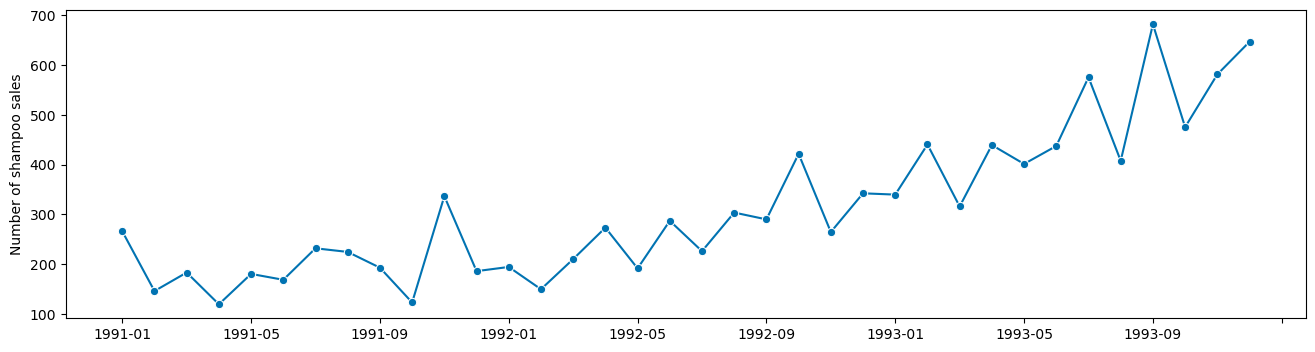

In [51]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()

fig, ax = plot_series(y)

The classical way of checking this is by analyzing the autocorrelation plots. This can be easily done with `sktime`

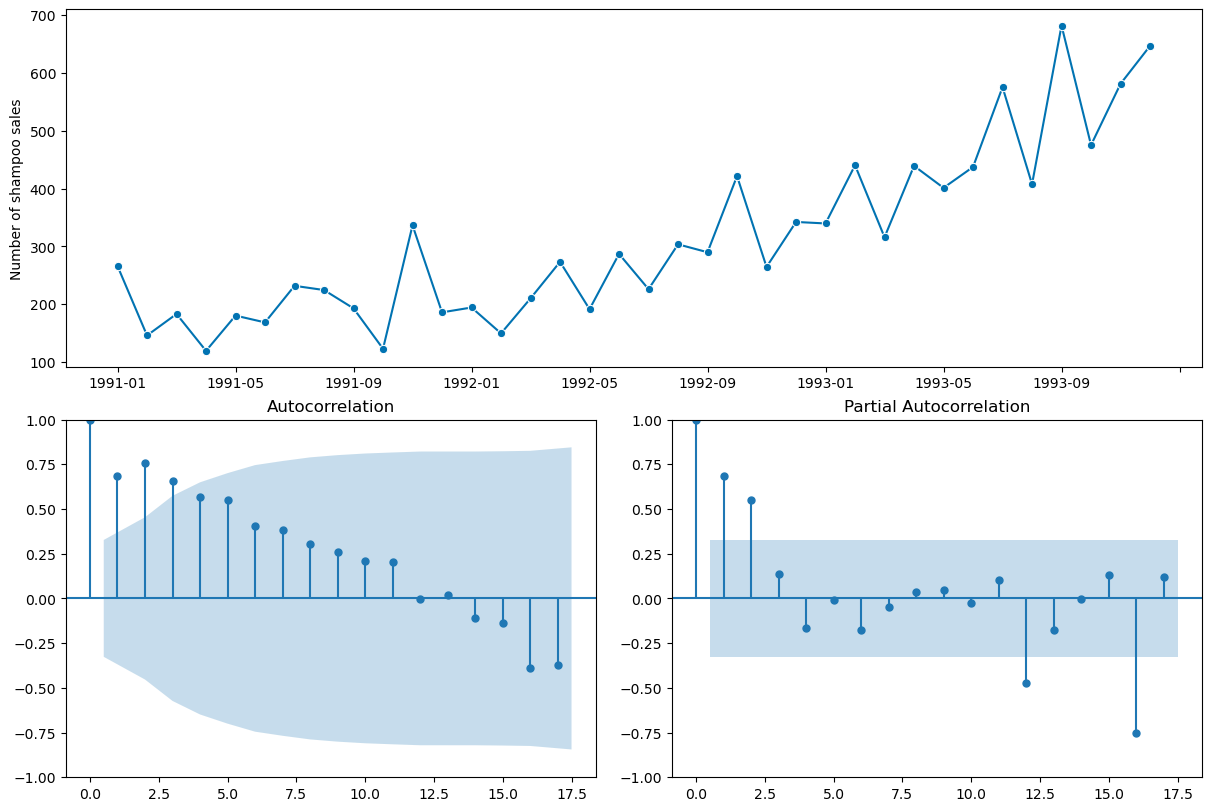

In [54]:
from sktime.utils.plotting import plot_correlations

fig, ax = plot_correlations(y, lags=17)

But we can use transformers to help with the decision-making step.

## 2.3 Combining transformers, feature engineering

transformers are natural pipeline components

* data processing steps
* feature engineering steps
* post processing steps

they can be combined in a number of other ways:

* pipelining = sequential chaining
* feature union = parallel, addition of features
* feature subsetting = selecting columns
* inversion = switch transform and inverse
* multiplexing = switching between transformers
* passthrough = switch on/ off

### Chaining transformers via `*`

In [37]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.summarize import SummaryTransformer

pipe = Differencer() * SummaryTransformer()

# this constructs a TransformerPipeline, which is also a transformer
pipe

TransformerPipeline(steps=[Differencer(), SummaryTransformer()])

In [38]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# this is a transformer with the same interface
# first applies differencer, then summary transform
pipe.fit_transform(X)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,2.222222,33.636569,-101.0,87.00,-37.700,-16.000,3.50,22.25,43.000
1,48.111111,810.876526,-2680.3,2416.86,-826.462,-323.145,76.33,448.86,1021.974


compatible with sklearn transformers!

default applies sklearn transformer per individual time series as a data frame table

In [39]:
from sklearn.preprocessing import StandardScaler

pipe = Differencer() * StandardScaler()

pipe

TransformerPipeline(steps=[Differencer(),
                           TabularToSeriesAdaptor(transformer=StandardScaler())])

In [40]:
pipe.fit_transform(X)

passengers
l1_agg    timepoints            
l1_node01 1949-01      -0.066296
          1949-02       0.112704
          1949-03       0.351370
          1949-04      -0.155796
          1949-05      -0.304963
...                          ...
l1_node02 1960-08      -0.623659
          1960-09      -3.376512
          1960-10      -1.565994
          1960-11      -2.231567
          1960-12       1.210249

[288 rows x 1 columns]

pipeline-adaptor chains can be constructed manually:

* `sktime.transformations.compose.TransformerPipeline`
* `sktime.transformations.series.adapt.TabularToSeriesAdaptor` for `sklearn`

composites are compatible with `get_params` / `set_params` parameter interface:

In [41]:
pipe.get_params()

{'steps': [Differencer(),
  TabularToSeriesAdaptor(transformer=StandardScaler())],
 'Differencer': Differencer(),
 'TabularToSeriesAdaptor': TabularToSeriesAdaptor(transformer=StandardScaler()),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'TabularToSeriesAdaptor__fit_in_transform': False,
 'TabularToSeriesAdaptor__transformer__copy': True,
 'TabularToSeriesAdaptor__transformer__with_mean': True,
 'TabularToSeriesAdaptor__transformer__with_std': True,
 'TabularToSeriesAdaptor__transformer': StandardScaler()}

### Feature union via `+`

In [42]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Differencer() + Lag()

# this constructs a FeatureUnion, which is also a transformer
pipe

FeatureUnion(transformer_list=[Differencer(), Lag()])

In [43]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# applies both Differencer and Lag, returns transformed in different columns
pipe.fit_transform(X)

Differencer__passengers  Lag__lag_0__passengers
l1_agg    timepoints                                                 
l1_node01 1949-01                        0.00                  112.00
          1949-02                        6.00                  118.00
          1949-03                       14.00                  132.00
          1949-04                       -3.00                  129.00
          1949-05                       -8.00                  121.00
...                                       ...                     ...
l1_node02 1960-08                    -1920.80                38845.27
          1960-09                   -10759.42                28085.85
          1960-10                    -4546.78                23539.07
          1960-11                    -6114.52                17424.55
          1960-12                     3507.42                20931.97

[288 rows x 2 columns]

to retain the original columns, use the `Id` transformer:

In [44]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer() + Lag([1, 2], index_out="original")

pipe.fit_transform(X)

Id__passengers  Differencer__passengers  \
l1_agg    timepoints                                            
l1_node01 1949-01             112.00                     0.00   
          1949-02             118.00                     6.00   
          1949-03             132.00                    14.00   
          1949-04             129.00                    -3.00   
          1949-05             121.00                    -8.00   
...                              ...                      ...   
l1_node02 1960-08           38845.27                 -1920.80   
          1960-09           28085.85                -10759.42   
          1960-10           23539.07                 -4546.78   
          1960-11           17424.55                 -6114.52   
          1960-12           20931.97                  3507.42   

                      Lag__lag_1__passengers  Lag__lag_2__passengers  
l1_agg    timepoints                                                  
l1_node01 1949-01                        NaN                     NaN  
          1949-02                     112.00                     NaN  
          1949-03                     118.00                  112.00  
          1949-04                     132.00                  118.00  
          1949-05                     129.00                  132.00  
...                                      ...                     ...  
l1_node02 1960-08                   40766.07                30877.65  
          1960-09                   38845.27                40766.07  
          1960-10                   28085.85                38845.27  
          1960-11                   23539.07                28085.85  
          1960-12                   17424.55                23539.07  

[288 rows x 4 columns]

In [45]:
# parameter inspection
pipe.get_params()

{'flatten_transform_index': True,
 'n_jobs': None,
 'transformer_list': [Id(),
  Differencer(),
  Lag(index_out='original', lags=[1, 2])],
 'transformer_weights': None,
 'Id': Id(),
 'Differencer': Differencer(),
 'Lag': Lag(index_out='original', lags=[1, 2]),
 'Id___output_convert': 'auto',
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'Lag__flatten_transform_index': True,
 'Lag__freq': None,
 'Lag__index_out': 'original',
 'Lag__keep_column_names': False,
 'Lag__lags': [1, 2]}

### Subset input columns via `[colname]`

let's say we want to apply `Differencer` to column 0, and `Lag` to column 1

also we keep the original columns for illustration

In [46]:
from sktime.utils._testing.hierarchical import _make_hierarchical

X = _make_hierarchical(
    hierarchy_levels=(2, 2), n_columns=2, min_timepoints=3, max_timepoints=3
)

X

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  3.356766  2.649204
          2000-01-02  2.262487  2.204119
          2000-01-03  2.087692  2.186494
     h1_1 2000-01-01  4.311237  3.129610
          2000-01-02  3.190134  1.747807
          2000-01-03  4.231399  2.483151
h0_1 h1_0 2000-01-01  4.356575  3.550554
          2000-01-02  2.865619  2.783107
          2000-01-03  3.781770  2.619533
     h1_1 2000-01-01  3.113704  1.000000
          2000-01-02  2.673081  2.561047
          2000-01-03  1.000000  2.953516

In [47]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer()["c0"] + Lag([1, 2], index_out="original")["c1"]

pipe.fit_transform(X)

Id__c0    Id__c1  TransformerPipeline_1__c0  \
h0   h1   time                                                        
h0_0 h1_0 2000-01-01  3.356766  2.649204                   0.000000   
          2000-01-02  2.262487  2.204119                  -1.094279   
          2000-01-03  2.087692  2.186494                  -0.174795   
     h1_1 2000-01-01  4.311237  3.129610                   0.000000   
          2000-01-02  3.190134  1.747807                  -1.121103   
          2000-01-03  4.231399  2.483151                   1.041265   
h0_1 h1_0 2000-01-01  4.356575  3.550554                   0.000000   
          2000-01-02  2.865619  2.783107                  -1.490956   
          2000-01-03  3.781770  2.619533                   0.916151   
     h1_1 2000-01-01  3.113704  1.000000                   0.000000   
          2000-01-02  2.673081  2.561047                  -0.440623   
          2000-01-03  1.000000  2.953516                  -1.673081   

                      TransformerPipeline_2__lag_1__c1  \
h0   h1   time                                           
h0_0 h1_0 2000-01-01                               NaN   
          2000-01-02                          2.649204   
          2000-01-03                          2.204119   
     h1_1 2000-01-01                               NaN   
          2000-01-02                          3.129610   
          2000-01-03                          1.747807   
h0_1 h1_0 2000-01-01                               NaN   
          2000-01-02                          3.550554   
          2000-01-03                          2.783107   
     h1_1 2000-01-01                               NaN   
          2000-01-02                          1.000000   
          2000-01-03                          2.561047   

                      TransformerPipeline_2__lag_2__c1  
h0   h1   time                                          
h0_0 h1_0 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          2.649204  
     h1_1 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          3.129610  
h0_1 h1_0 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          3.550554  
     h1_1 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          1.000000

auto-generated names can be replaced by using `FeatureUnion` explicitly:

In [48]:
from sktime.transformations.compose import FeatureUnion

pipe = FeatureUnion(
    [
        ("original", Id()),
        ("diff", Differencer()["c0"]),
        ("lag", Lag([1, 2], index_out="original")),
    ]
)

pipe.fit_transform(X)

original__c0  original__c1  diff__c0  lag__lag_1__c0  \
h0   h1   time                                                               
h0_0 h1_0 2000-01-01      3.356766      2.649204  0.000000             NaN   
          2000-01-02      2.262487      2.204119 -1.094279        3.356766   
          2000-01-03      2.087692      2.186494 -0.174795        2.262487   
     h1_1 2000-01-01      4.311237      3.129610  0.000000             NaN   
          2000-01-02      3.190134      1.747807 -1.121103        4.311237   
          2000-01-03      4.231399      2.483151  1.041265        3.190134   
h0_1 h1_0 2000-01-01      4.356575      3.550554  0.000000             NaN   
          2000-01-02      2.865619      2.783107 -1.490956        4.356575   
          2000-01-03      3.781770      2.619533  0.916151        2.865619   
     h1_1 2000-01-01      3.113704      1.000000  0.000000             NaN   
          2000-01-02      2.673081      2.561047 -0.440623        3.113704   
          2000-01-03      1.000000      2.953516 -1.673081        2.673081   

                      lag__lag_1__c1  lag__lag_2__c0  lag__lag_2__c1  
h0   h1   time                                                        
h0_0 h1_0 2000-01-01             NaN             NaN             NaN  
          2000-01-02        2.649204             NaN             NaN  
          2000-01-03        2.204119        3.356766        2.649204  
     h1_1 2000-01-01             NaN             NaN             NaN  
          2000-01-02        3.129610             NaN             NaN  
          2000-01-03        1.747807        4.311237        3.129610  
h0_1 h1_0 2000-01-01             NaN             NaN             NaN  
          2000-01-02        3.550554             NaN             NaN  
          2000-01-03        2.783107        4.356575        3.550554  
     h1_1 2000-01-01             NaN             NaN             NaN  
          2000-01-02        1.000000             NaN             NaN  
          2000-01-03        2.561047        3.113704        1.000000

### turning log transform into exp transform via invert `~`

In [49]:
import numpy as np

from sktime.transformations.series.boxcox import LogTransformer

log = LogTransformer()

exp = ~log

# this behaves like an "e to the power of" transformer now
exp.fit_transform(np.array([1, 2, 3]))

array([ 2.71828183,  7.3890561 , 20.08553692])

### autoML structure compositors: multiplexer switch `¦` and on/off switch `-`

expose decisions as parameter

* do we want differencer *or* lag? for tuning later
* do we want [differencer and lag] or [original features and lag] ? for tuning later

In [50]:
# differencer or lag

from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Differencer() | Lag()

pipe.get_params()

{'selected_transformer': None,
 'transformers': [Differencer(), Lag()],
 'Differencer': Differencer(),
 'Lag': Lag(),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'Lag__flatten_transform_index': True,
 'Lag__freq': None,
 'Lag__index_out': 'extend',
 'Lag__keep_column_names': False,
 'Lag__lags': 0}

the `selected_transformer` parameter exposes the choice:

does this behave as `Lag` or `Differencer`?

In [51]:
# switch = Lag -> this is a Lag transformer now!
pipe.set_params(selected_transformer="Lag")

MultiplexTransformer(selected_transformer='Lag',
                     transformers=[Differencer(), Lag()])

In [52]:
# switch = Lag -> this is a Differencer now!
pipe.set_params(selected_transformer="Differencer")

MultiplexTransformer(selected_transformer='Differencer',
                     transformers=[Differencer(), Lag()])

similar, on/off switch with `~`

same as multiplexer between wrapped transformer and `Id`

In [53]:
optional_differencer = -Differencer()

# this behaves as Differencer now
optional_differencer

OptionalPassthrough(transformer=Differencer())

In [54]:
# this is now just the identity transformer
optional_differencer.set_params(passthrough=True)

OptionalPassthrough(passthrough=True, transformer=Differencer())

see more later in part 3 on how to use this with tuning for full structural AutoML!

## Pipelines in action: AutoML with `sktime`

Let's begin by loading the data for which to do AutoML on and split into train and test.

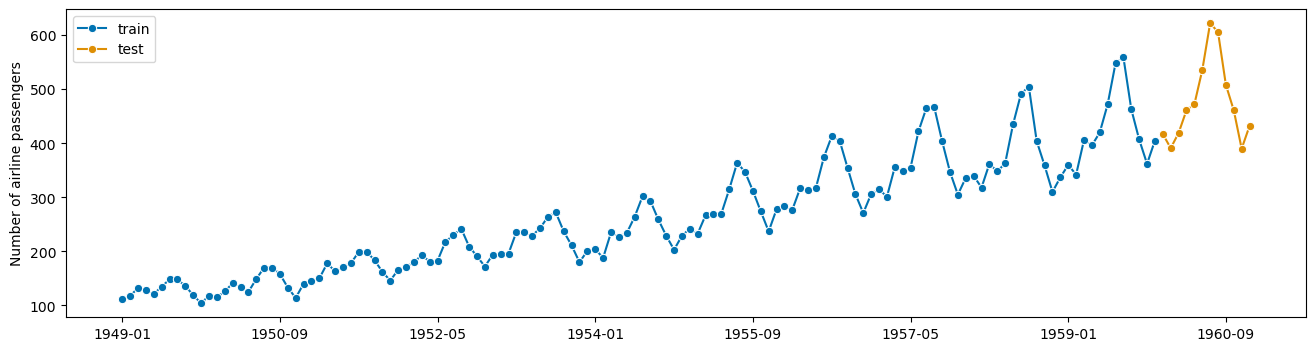

In [39]:
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.datasets import load_airline

y = load_airline()

y_train, y_test = temporal_train_test_split(y=y, test_size=12)
fig, ax = plot_series(y_train, y_test, labels=["train", "test"])

Now we define the sklearn tree-based regressor and create a forecaster from it using `make_reduction`.

In [40]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction

regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=12)

In this step we create a pipeline with the all the different steps we wish to try out.

In [41]:
from sklearn.preprocessing import RobustScaler

from sktime.transformations.compose import OptionalPassthrough
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Detrender, Deseasonalizer

forecasting_pipeline = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("differencer", OptionalPassthrough(Differencer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", forecaster),
    ]
)

We would now need to define the parametr grid for thee grid search. 

To see what are the available options we can inspect the parameters of the pipeline object.

In [42]:
forecasting_pipeline.get_params()

{'steps': [('detrender', OptionalPassthrough(transformer=Detrender())),
  ('deseasonalizer', OptionalPassthrough(transformer=Deseasonalizer())),
  ('differencer', OptionalPassthrough(transformer=Differencer())),
  ('scaler',
   OptionalPassthrough(transformer=TabularToSeriesAdaptor(transformer=RobustScaler()))),
  ('forecaster',
   DirectTabularRegressionForecaster(estimator=HistGradientBoostingRegressor(),
                                     window_length=12))],
 'detrender': OptionalPassthrough(transformer=Detrender()),
 'deseasonalizer': OptionalPassthrough(transformer=Deseasonalizer()),
 'differencer': OptionalPassthrough(transformer=Differencer()),
 'scaler': OptionalPassthrough(transformer=TabularToSeriesAdaptor(transformer=RobustScaler())),
 'forecaster': DirectTabularRegressionForecaster(estimator=HistGradientBoostingRegressor(),
                                   window_length=12),
 'detrender__passthrough': False,
 'detrender__transformer__forecaster': None,
 'detrender__tra

In [43]:
param_grid = {
    "detrender__passthrough": [True, False],
    "deseasonalizer__passthrough": [True, False],
    "differencer__passthrough": [True, False],
    "scaler__passthrough": [True, False],
    "forecaster__window_length": [6, 12, 18],
    "forecaster__estimator__learning_rate": [0.1, 0.2], # Note we can also access the regressor parameters
}

Now let's set up the cross validation strategy

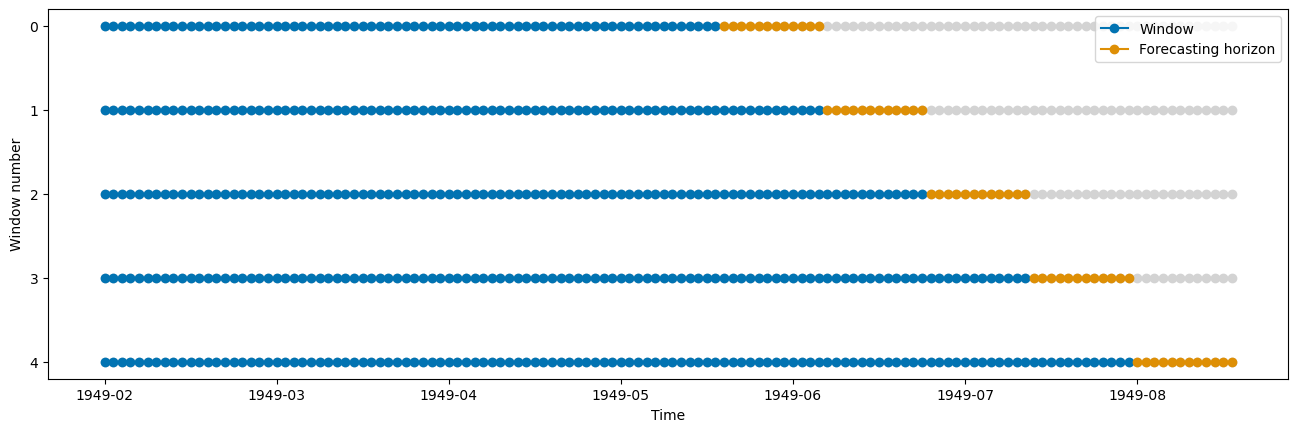

In [44]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils.plotting import plot_windows

fh = list(range(1, 13))
cv = ExpandingWindowSplitter(initial_window=12*6, fh=fh, step_length=len(fh))
n_folds = cv.get_n_splits(y_train)
plot_windows(cv, y_train)

In [45]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

gscv = ForecastingGridSearchCV(
    forecaster=forecasting_pipeline,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=smape,
    error_score="raise",
)

gscv.fit(y=y_train, fh=fh)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=[1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12],
                                                   initial_window=72,
                                                   step_length=12),
                        error_score='raise',
                        forecaster=TransformedTargetForecaster(steps=[('detrender',
                                                                       OptionalPassthrough(transformer=Detrender())),
                                                                      ('deseasonalizer',
                                                                       OptionalPassthrough(transformer=Deseasonalizer())),
                                                                      ('differencer',
                                                                       OptionalPassthrough(tran...
                                                                       DirectTabularRegressionForecaster(estimator=HistGradientBoostingRegressor(),
                                                                                                         window_length=12))]),
                        n_jobs=-1,
                        param_grid={'deseasonalizer__passthrough': [True,
                                                                    False],
                                    'detrender__passthrough': [True, False],
                                    'differencer__passthrough': [True, False],
                                    'forecaster__estimator__learning_rate': [0.1,
                                                                             0.2],
                                    'forecaster__window_length': [6, 12, 18],
                                    'scaler__passthrough': [True, False]},
                        scoring=MeanAbsolutePercentageError(symmetric=True),
                        verbose=1)

We can now inspect the grid search object to see which was the best model and why.

In [46]:
gscv.best_forecaster_

TransformedTargetForecaster(steps=[('detrender',
                                    OptionalPassthrough(transformer=Detrender())),
                                   ('deseasonalizer',
                                    OptionalPassthrough(passthrough=True,
                                                        transformer=Deseasonalizer())),
                                   ('differencer',
                                    OptionalPassthrough(transformer=Differencer())),
                                   ('scaler',
                                    OptionalPassthrough(transformer=TabularToSeriesAdaptor(transformer=RobustScaler()))),
                                   ('forecaster',
                                    DirectTabularRegressionForecaster(estimator=HistGradientBoostingRegressor(learning_rate=0.2),
                                                                      window_length=6))])

In [47]:
gscv.cv_results_.sort_values(by=f"rank_test_MeanAbsolutePercentageError")

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
43,0.067779,1.134767,0.082764,"{'deseasonalizer__passthrough': True, 'detrend...",1.5
91,0.067779,1.038031,0.090483,"{'deseasonalizer__passthrough': False, 'detren...",1.5
42,0.067779,1.131953,0.090737,"{'deseasonalizer__passthrough': True, 'detrend...",3.5
90,0.067779,1.061098,0.079214,"{'deseasonalizer__passthrough': False, 'detren...",3.5
18,0.069984,1.144443,0.080575,"{'deseasonalizer__passthrough': True, 'detrend...",5.5
...,...,...,...,...,...
48,0.196330,1.191868,0.091048,"{'deseasonalizer__passthrough': False, 'detren...",91.5
7,0.197435,1.133143,0.075055,"{'deseasonalizer__passthrough': True, 'detrend...",93.5
55,0.197435,1.186639,0.085519,"{'deseasonalizer__passthrough': False, 'detren...",93.5
6,0.197435,1.109218,0.080573,"{'deseasonalizer__passthrough': True, 'detrend...",95.5


Finally we can use the best performing forecaster in thee backtests to make predictions.

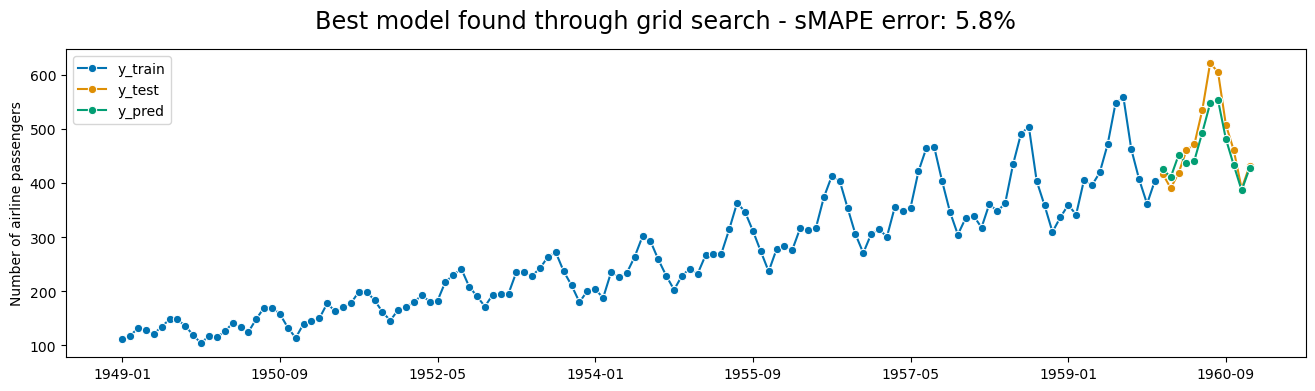

In [48]:
y_pred = gscv.predict(fh=fh)
title = f"Best model found through grid search - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title)